<a href="https://colab.research.google.com/github/Alexis-CAPON/cse437-reinforcement-learning/blob/main/lab9_mountain_optimal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Predictive Control (MPC) for the Mountain Car

## Exercise 1
In this exercise, you will implement **Model Predictive Control (MPC)** using a **random shooting method** to solve the **Mountain Car** problem.

You will complete the `mpc_action()` function, which chooses the best action sequence by simulating multiple random trajectories into the future and selecting the one with the lowest total cost.

---

## ⚙️ Environment Description
You are working with a **simplified Mountain Car** environment, where the goal is to reach and stay near the top of the right hill (`x ≈ 0.45`).

The car’s state is:
- `x` → position  
- `v` → velocity  

The control input is:
- `u` → engine thrust in the range `[-1, 1]`

The dynamics are defined as:
\[
v_{t+1} = v_t + 0.0015 u_t - 0.0025 \cos(3x_t)
\]
\[
x_{t+1} = x_t + v_{t+1}
\]

---

## 🚀 Task
Your task is to **implement mpc_action function for the MPC controller**.

At each step:
1. You will **sample random sequences of actions** for the next `H` steps.
2. You will **simulate** the effect of each sequence on the system using a provided dynamics model.
3. You will **compute the total cost** of each simulated trajectory.
4. You will **choose the best trajectory** (lowest cost) and apply its first action.

---

## ✅ Deliverables
* The completed mpc_action() function.
* A short report (few paragraphs) answering:
    * How does random shooting choose the best action?
    * How does changing H or N_seq affect the result?
    * Did your car reach and stay near the goal?

In [ ]:
%matplotlib inline

# Setup environment and collect initial data

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# Environment setup
# --------------------------------------------------------------
env = gym.make("MountainCarContinuous-v0", max_episode_steps=500)

### Dynamics
This is the underneath dynamics in the mountain car. For this exercise, we will use it, but for the following sessions, **we will learn it!**

In [ ]:
def mountain_car_dynamics(p, v, a):
    v_next = v + 0.001 * a - 0.0025 * np.cos(3 * p)
    v_next = np.clip(v_next, -0.07, 0.07)
    p_next = p + v_next
    if p_next < -1.2:
        p_next, v_next = -1.2, 0.0
    return np.array([p_next, v_next])

# Test dynamics, at position p, and velocity v, predict the new location when the action a=1 is applied.
mountain_car_dynamics(p=-0.5, v=0, a=1.0)

array([-0.49917684,  0.00082316])

### Cost function

In [ ]:
def cost_fn(state, a):
    x, v = state
    goal = 0.5
    target = goal - x

    # Encourage moving in the right direction and gaining kinetic energy
    cost = target**2 - 1000 * np.abs(v)
    return cost

## Roll out trajectories based on action sequences U

In [ ]:
def roll_out_trajectory(s0, Ui, gamma=1.0):
    s = s0.copy()  # Initial state
    traj = [s0.copy()]  # Trajectory
    H = len(Ui)
    discount = 1.0

    total_cost = 0.0

    # For each time in the planning horizon
    for k in range(H):
        a = Ui[k]  # continuous action in [-1, 1]
        delta_m = np.zeros(2)

        # Predict Δx using both GPs (for Δp, Δv)
        s = mountain_car_dynamics(s[0], s[1], a)
        traj.append(s.copy())

        # Accumulate discounted cost
        total_cost += cost_fn(s, a) * discount
        discount *= gamma
    return np.array(traj), total_cost


def roll_out_n_trajectories(state, U):
    N_seq = len(U)
    J = np.zeros(N_seq)

    # Roll out trajectories and computer their cost
    all_traj = []
    for i in range(N_seq):
        traj, total_cost = roll_out_trajectory(state, U[i])

        J[i] = total_cost
        all_traj.append(np.array(traj))

    return all_traj, J

# Action squence
Ui = np.zeros(3)
traj, J = roll_out_trajectory(np.array([-0.5,0]), Ui)
traj

array([[-5.00000000e-01,  0.00000000e+00],
       [-5.00176843e-01, -1.76843004e-04],
       [-5.00529206e-01, -3.52362983e-04],
       [-5.01054453e-01, -5.25246664e-04]])

In [ ]:
def plot_trajectories(state, best_traj):
    plt.figure(figsize=(8, 6))
    for i, traj in enumerate(best_traj):
        plt.plot(traj[:, 0], traj[:, 1], lw=2, alpha=0.8, label=f"Traj {i+1}")
    plt.scatter(state[0], state[1], color='red', s=60, label="Start", zorder=5)
    plt.axvline(0.5, color='gray', ls='--', label='Goal position')
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title(f"Predicted Trajectories (Continuous MPC)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Finding optimal action for MPC (Random Shooting)

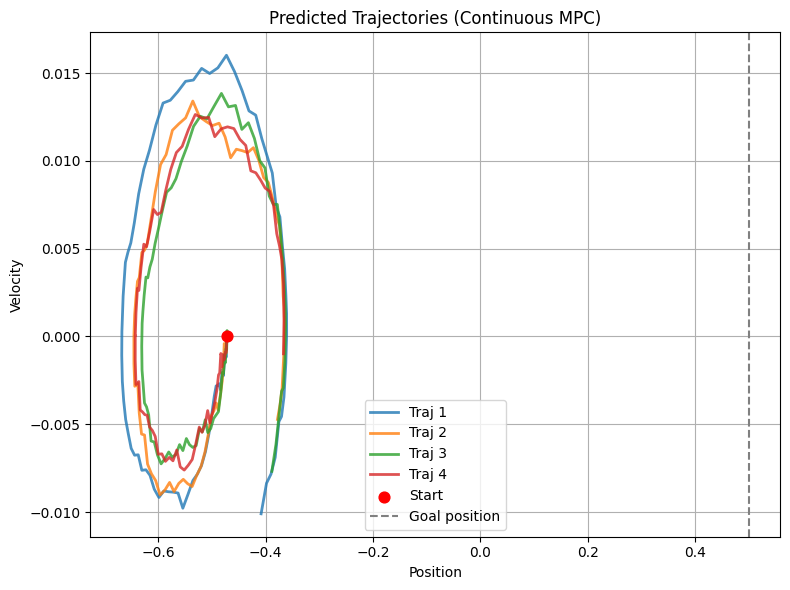

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------------
#  MPC (Random Shooting)
# --------------------------------------------------------------

def mpc_action(state, H=25, N_seq=200, plot=False, plot_best=10, repeat=5):
    """
    Random Shooting MPC for continuous actions in [-1, 1].
    Each GP predicts Δposition and Δvelocity given (pos, vel, action).
    """

    ########### TODO ####################
    # 1. Sample action sequences
    # Generate N_seq random action sequences, each of length H
    random_sequences_action = np.random.uniform(low=-1.0, high=1.0, size=(N_seq, H))

    # 2. Roll out trajectories
    all_traj, J = roll_out_n_trajectories(state, random_sequences_action)

    # 3. Select top trajectories
    # Find the indices of the sequences with the lowest costs
    best_idx = np.argsort(J)

    # Plot the best predicted trajectories
    if plot:
        best_traj = [all_traj[i] for i in best_idx[:plot_best]]
        plot_trajectories(state, best_traj)

    # 4. Return the first action of the best sequence
    best_action = random_sequences_action[best_idx[0], 0]
    return best_action


obs, _ = env.reset(seed=0)
a = mpc_action(obs, H=80, N_seq=100, plot=True, plot_best=4)

In [ ]:
# --------------------------------------------------------------
# Running in the gym environment
# --------------------------------------------------------------
H = 80        # MPC horizon
N_seq = 200   # Number of sampled action sequences
steps = 500   # Max episode length


obs, _ = env.reset()
returns = 0.0
a = 0.0       # initial action

trajectory = []

for t in range(steps):
    # --- 1. Compute optimal action via MPC ---
    a = mpc_action(obs, H=H, N_seq=N_seq)

    if t%10==0:
        print("t=",t, "state=", obs, "a=",a)

    # --- 2. Step environment ---
    next_obs, r, term, trunc, _ = env.step([a])  # continuous env expects array-like
    trajectory.append([obs,a])
    env.render()  # draw each step

    returns += r

    # --- 5. Prepare next step ---
    obs = next_obs
    if term or trunc:
        break

print(f"Episode return: {returns:.2f}")
env.close()


t= 0 state= [-0.5460427  0.       ] a= -0.7995697858605468


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/classic_control/continuous_mountain_car.py:202: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
  gym.logger.warn(


t= 10 state= [-0.55414015 -0.00135424] a= -0.329483942114037
t= 20 state= [-0.5386835   0.00260777] a= 0.05085128417204143
t= 30 state= [-0.4836199   0.00624178] a= 0.9587401902238164
t= 40 state= [-0.40970448  0.00741522] a= 0.09498656103530312
t= 50 state= [-0.37991607 -0.00345456] a= -0.032693026387112134
t= 60 state= [-0.48805687 -0.01713349] a= -0.6803791294812587
t= 70 state= [-0.69993854 -0.02016269] a= -0.8944646131937957
t= 80 state= [-0.85576105 -0.00882416] a= 0.5796269845237063
t= 90 state= [-0.8103455   0.01561507] a= -0.20045240811990594
t= 100 state= [-0.5489652   0.03443946] a= -0.24289094974064307
t= 110 state= [-0.20543611  0.02930161] a= 0.4371219873844461
t= 120 state= [-0.03483139  0.00725085] a= -0.5525070986709733
t= 130 state= [-0.14170338 -0.02523783] a= -0.5075097547003502
t= 140 state= [-0.52336776 -0.04445515] a= -0.4446196705760397
t= 150 state= [-0.9712815  -0.04066906] a= 0.20233455703751213
t= 160 state= [-1.1937135   0.00451999] a= 0.29651713205274444
t

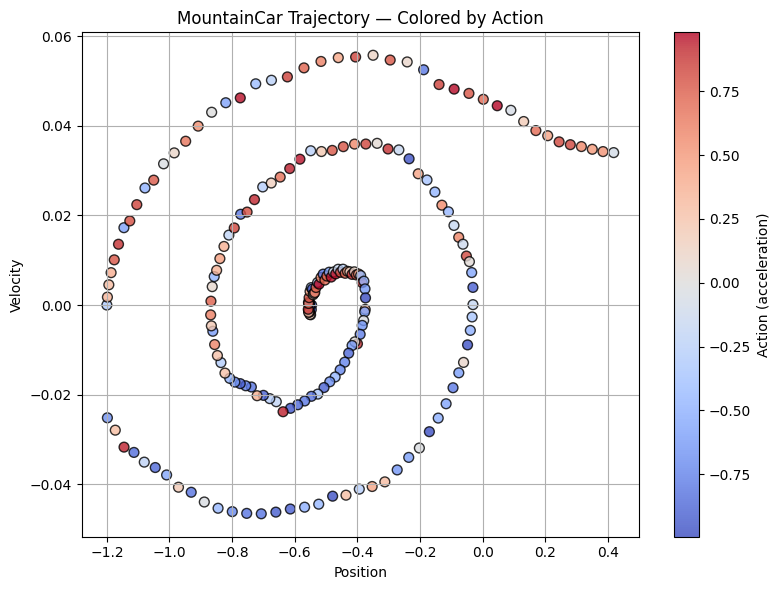

In [ ]:
# trajectory is a list of [obs, a]
# each obs is [pos, vel]

def plot_trajectory(trajectory):
    positions, velocities, actions = [], [], []

    for entry in trajectory:
        obs, a = entry
        positions.append(obs[0])
        velocities.append(obs[1])
        actions.append(float(a))  # ensure scalar

    positions = np.array(positions)
    velocities = np.array(velocities)
    actions = np.array(actions)

    # --------------------------------------------------------------
    # Scatter plot: position vs velocity, colored by action
    # --------------------------------------------------------------
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(positions, velocities, c=actions,
                     cmap='coolwarm', s=50, edgecolor='k', alpha=0.8)

    cbar = plt.colorbar(sc, label="Action (acceleration)")
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title("MountainCar Trajectory — Colored by Action")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_trajectory(trajectory)

**How does random shooting choose the best action?**
It will generate a number of random action sequences for each H, then simulate the effect with the dynamics model, it calculate a cost and then we pick the one with the lowest cost

**How does changing H or N_seq affect the result?**
If we increasing H, it can lead to better long term planning and more optimal trajectories. However, it also increases the computational cost of simulating more steps. If H is too short, the controller might not be able to plan effectively to reach the goal.
If we increase N_seq, it increases the exploration of the possible action space.

**Did your car reach and stay near the goal?**
Yes the car reach and stay at the goal

# 🧩 Exercise 2: Implement the MPPI Controller

In this exercise, you will complete the **`action()` method** of the `MPPIController` class.  
This method implements the **Model Predictive Path Integral (MPPI)** algorithm, which selects an optimal control action based on sampled action sequences and their simulated costs.

---

## ⚙️ MPPI Overview

Model Predictive Path Integral (MPPI) control is a **sampling-based model predictive controller**.  
It explores many possible future action sequences and evaluates them under a dynamics model.  
Unlike random shooting, MPPI adds **Gaussian noise around a mean sequence** and keeps track of a **persistent best sequence** that shifts at every step.

At each time step:

1. **Shift** the previous mean action sequence (`U_mean`) forward in time.  
   → This reuses information from the last solution.

2. **Sample** new action sequences by adding Gaussian noise around this mean.

3. **Roll out** each sequence using the system dynamics to compute its total cost.

4. Mean computation:
   * For undergraduate: **Select** the best trajectory (the one with the lowest cost) as the mean. (MPPI Simplified version)
   * For graduate: Compute **importance-weighted averages of control perturbations**, following the path-integral formulation of stochastic optimal control.

6. **Return** the first action of the best sequence to apply to the system.

---
# 🧩 Deliverables

* The completed action() method implementation.

* A short explanation (1–2 paragraphs) describing how your controller selects actions and how it differs from random shooting.

* Questions for Discussion

    * Why does MPPI reuse the previous mean sequence (U_mean)?

    * What would happen if we didn’t shift it each iteration?

    * How does the horizon H affect stability and responsiveness?

    * Compare MPPI to random shooting — what advantage does MPPI bring?


# MPPI

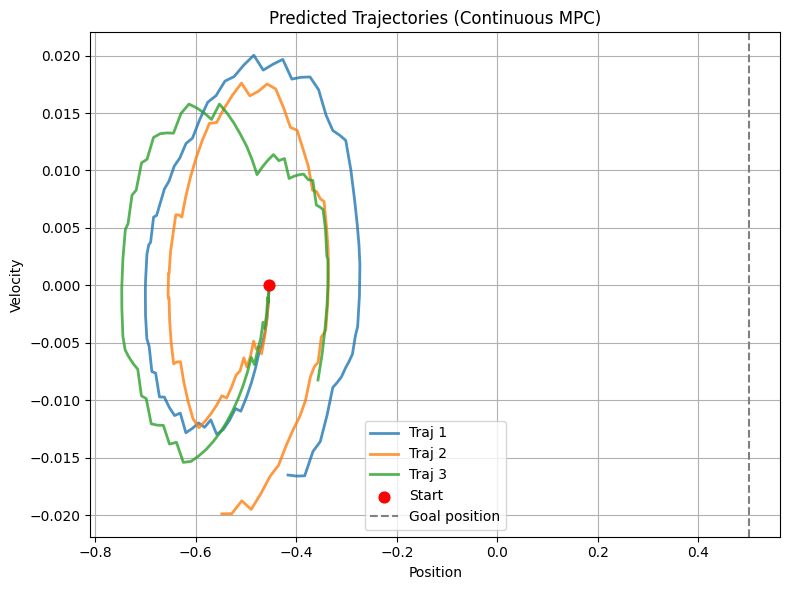

np.float64(-1.0)

In [20]:
import numpy as np
import matplotlib.pyplot as plt

class MPPIController:
    def __init__(self, H=100, N_seq=200, λ=1.0, σ=0.3):
        """
        Model Predictive Path Integral Controller with persistent action sequence.
        Uses the best trajectory (lowest-cost) to update instead of weighted mean.
        """
        self.H = H
        self.N_seq = N_seq
        self.λ = λ
        self.σ = σ


        # Persistent mean sequence for warm-start
        self.U_mean = np.zeros(H)

    def action(self, state, plot=False, plot_best=3):
        H, N_seq, σ = self.H, self.N_seq, self.σ

        ######## TODO #############
        # 0 Shift previous mean sequence (reuse previous solution)
        self.U_mean[:-1] = self.U_mean[1:]
        self.U_mean[-1] = 0.0

        # 1. Sample action sequences (Gaussian noise around previous U_mean)
        noise = np.random.normal(loc=0, scale=σ, size=(N_seq, H))
        action_sequences = np.clip(self.U_mean + noise, -1.0, 1.0)


        # 2. Roll out trajectories
        all_traj, J = roll_out_n_trajectories(state, action_sequences)

        # 3. Select the best trajectory (lowest cost)
        best_idx = np.argmin(J)
        self.U_mean = action_sequences[best_idx, :]

        #  Optional: plot best trajectories
        if plot:
            best_k = np.argsort(J)[:plot_best]
            best_traj = [all_traj[i] for i in best_k]
            plot_trajectories(state, best_traj)

        # 4. Return the first action of the best sequence
        best_action = self.U_mean[0]
        return best_action

# Initialize controller once
mppi = MPPIController(H=80, N_seq=150, λ=1.0, σ=2.1)

obs, _ = env.reset()
a = mppi.action(obs, plot=True, plot_best=3)  # plot first iteration only
a

In [21]:
# Initialize controller once
mppi = MPPIController(H=30, N_seq=200, λ=.10, σ=.50)

obs, _ = env.reset(seed=0)
traj = []

for t in range(500):
    a = mppi.action(obs)  # plot first iteration only
    traj.append([obs, a])

    if t%10==0:
      print(t, obs, a)

    obs, r, term, trunc, _ = env.step([a])


    if term or trunc:
        break

print(f"Total time: {t:.0f}")


0 [-0.47260767  0.        ] -0.49075925664974757
10 [-0.5569212  -0.01512618] -1.0
20 [-0.75189656 -0.0201374 ] 0.16248411730940882
30 [-0.8242187   0.00526008] 0.338310517222563
40 [-0.62241995  0.03185976] 1.0
50 [-0.22969563  0.04106324] 0.9346929053168532
60 [0.0685064 0.0140955] -0.3620777468767242
70 [ 0.01175783 -0.02105062] 0.07595683330047531
80 [-0.3673534  -0.05272562] -1.0
90 [-0.9618607  -0.05808868] 0.5101055835118274
100 [-1.1453142   0.01845494] 0.8490494590811734
110 [-0.74832547  0.05647791] 1.0
120 [-0.08724297  0.06725218] 1.0
Total time: 128


<>:3: SyntaxWarning: invalid decimal literal
<>:3: SyntaxWarning: invalid decimal literal
/tmp/ipython-input-1621329264.py:3: SyntaxWarning: invalid decimal literal
  print("Energy", sum([a**2for s,a in traj]))


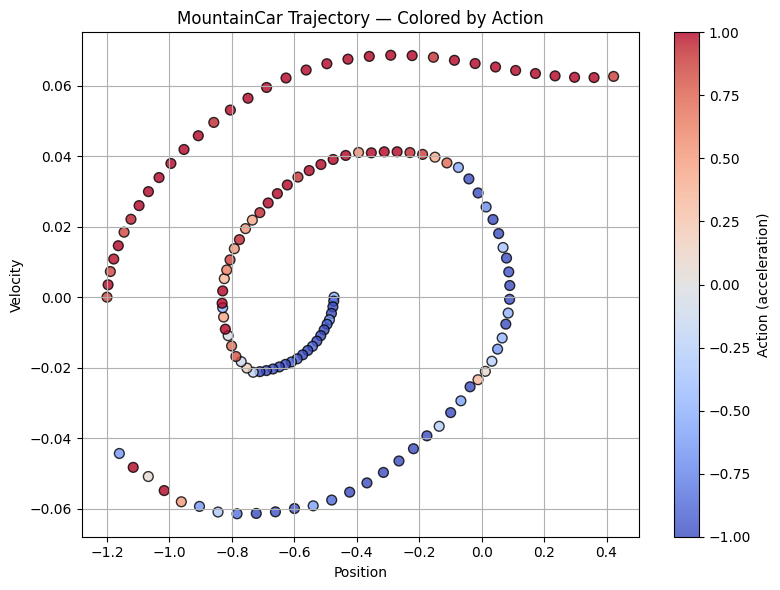

Energy 98.33940311499975


In [22]:
plot_trajectory(traj)

print("Energy", sum([a**2for s,a in traj]))

**Why does MPPI reuse the previous mean sequence (U_mean)?**
MPPI reuses the previous mean sequence as a warm-start for the optimization in the current time step. This is based on the assumption that the optimal control sequence at time t is likely to be similar to the optimal sequence at time t-1, just shifted forward by one time step. By starting the sampling around this shifted mean, MPPI can explore a more relevant region of the action space, leading to faster convergence and potentially better performance compared to sampling completely randomly at each step.

**What would happen if we didn’t shift it each iteration?**
If we didn't shift the mean sequence each iteration and instead started sampling around a fixed or unshifted mean, we would lose the benefit of the warm-start. The controller would essentially be re-solving the optimal control problem from scratch at each time step, similar to a basic random shooting method. This would likely lead to slower convergence, potentially more erratic control inputs, and could make it harder for the controller to maintain a smooth and efficient trajectory.

**How does the horizon H affect stability and responsiveness?**
A longer horizon improves stability because the controller will see future consequences of its actions over a longer period. This helps prevent short decisions that could lead to instability.
A shorter horizon can make the controller more responsive to immediate changes in the system state or environment because it focuses on optimizing over a shorter time frame. However, a very short horizon might lead to control that doesn't consider long-term goals and could result in oscillatory or unstable behavior.

**Compare MPPI to random shooting — what advantage does MPPI bring?**
The main advantage of MPPI over basic random shooting lies in its use of a persistent, shifting mean action sequence.

# 🧩 Exercise 3: Reward Engineering — Stop at the Goal and Save Energy

In this exercise you will explore **reward shaping** and how it changes robot behavior.  
You will modify the Mountain Car reward so that the robot:
1. **Stops at the goal** rather than overshooting it.  
2. **Uses minimal control effort** (energy efficiency).

The goal is to understand how each term in a reward function influences motion and stability.

---

## ⚙️ Background
In reinforcement learning and model-based control, the reward (or cost) encodes *what* we want the agent to do.  
A poorly designed reward may lead to:
- Unstable or oscillatory behavior  
- Excessive control effort  
- Agents that reach the goal but never stop  

The standard Mountain Car reward only gives a terminal bonus for reaching the goal:
\[
r = 100 \, \mathbf{1}[x \ge 0.45] - 0.1u^2
\]
It encourages reaching the hilltop but does **not** reward *staying there* or *saving energy*.

---

## 🧩 Tasks

### a) Make the robot **stop at the goal**
You will modify the reward so that the agent receives high reward when it is **close to the goal** *and* has **small velocity**.

Implement a new reward function that encourages being near the goal position, and make the car stop once it arrives.  


Test this reward inside your MPC or MPPI loop.  
Observe whether the car reaches the top and remains there.

---

### b) Make the robot **save energy**
Design a second version of the reward that explicitly penalizes energy use more strongly. The energy is proportional to the square of the control input **a**.


Run simulations again and compare:
- Does the car reach the goal more slowly?  
- Does it stop more gently?  
- How much smaller are the average control inputs?

---

## Hint
Take into account that the weights help to scale the magnitude of the variables. For example,

---
# ✅ Deliverables

* Two implemented reward functions:

    * (a) Stop-at-goal

    * (b) Energy-saving

* Position, velocity, and control plots for both cases.

* A short report (≈ 1 paragraph per reward) answering:

    * How did each reward affect the trajectory?

    * Which terms were most influential?

    * Did the car stop smoothly at the goal?


In [23]:
# Cost function to encourage stopping at the goal
def cost_fn_stop_at_goal(state, a):
    x, v = state
    goal = 0.45  # MountainCarContinuous-v0 goal is around 0.45
    target_pos_cost = (goal - x)**2  # Penalize distance from goal
    target_vel_cost = v**2 * 1000  # Penalize velocity at the goal (scaled)

    # Encourage reaching the goal and penalize velocity at the goal
    cost = target_pos_cost + target_vel_cost
    return cost

# Cost function to encourage energy saving
def cost_fn_energy_saving(state, a):
    x, v = state
    goal = 0.45
    target_pos_cost = (goal - x)**2  # Penalize distance from goal
    target_vel_cost = v**2 * 100 # Penalize velocity
    energy_cost = a**2 * 10 # Penalize energy usage (scaled)

    cost = target_pos_cost + target_vel_cost + energy_cost
    return cost

Running with 'stop at goal' cost function:
t=0, state=[-0.47260767  0.        ], a=0.34
t=50, state=[-0.2262298  -0.00586116], a=1.00
t=100, state=[-0.34321016  0.0071395 ], a=0.56
t=150, state=[-0.39747414 -0.00336142], a=1.00
t=200, state=[-0.2768017  -0.00111151], a=0.69
t=250, state=[-0.36329255  0.00297505], a=1.00
t=300, state=[-0.37655088 -0.00347571], a=1.00
t=350, state=[-0.28526342  0.00167194], a=0.85
t=400, state=[-0.3777962   0.00278155], a=0.72
t=450, state=[-0.33912516 -0.00249636], a=1.00
Total time: 499


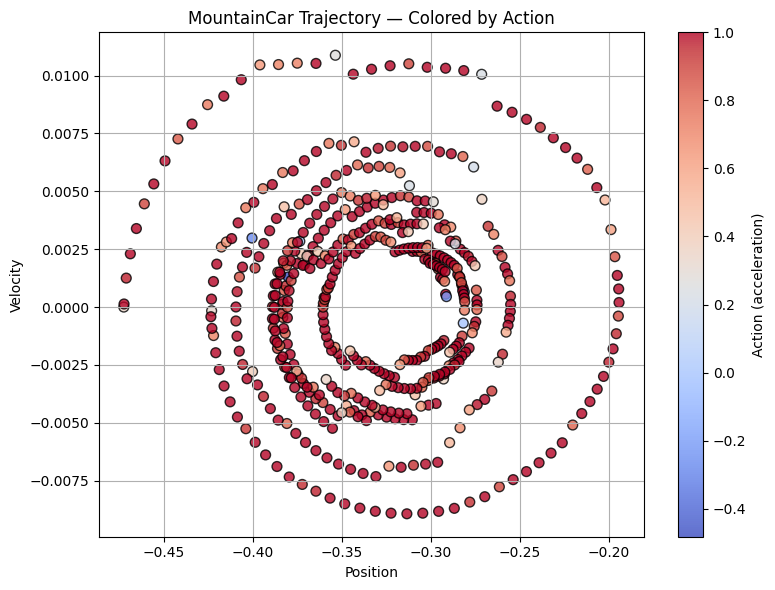

Energy 421.93985136261807

Running with 'energy saving' cost function:
t=0, state=[-0.47260767  0.        ], a=0.08
t=50, state=[-0.588501   -0.00100575], a=1.00
t=100, state=[-0.52204794 -0.00463047], a=-0.30
t=150, state=[-0.5266206   0.00371966], a=0.16
t=200, state=[-0.5565685  -0.00603076], a=-0.07
t=250, state=[-0.3890076  -0.00394654], a=0.39
t=300, state=[-0.5796917   0.01083384], a=0.51
t=350, state=[-0.60896647 -0.00954233], a=-0.78
t=400, state=[-0.4245103  -0.00133502], a=-0.52
t=450, state=[-0.5191437  0.0042322], a=-0.44
Total time: 499


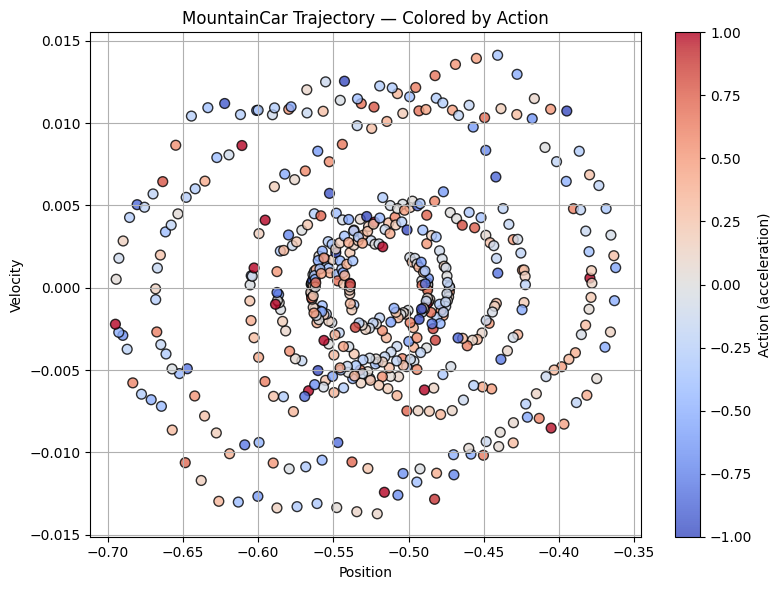

Energy 94.05208105655338


In [24]:
# --------------------------------------------------------------
# Running MPPI in the gym environment with 'stop at goal' cost
# --------------------------------------------------------------
print("Running with 'stop at goal' cost function:")
# Initialize controller with the 'stop at goal' cost function
mppi_stop = MPPIController(H=30, N_seq=200, λ=.10, σ=.50)
# Temporarily change the roll_out_trajectory to use the new cost function
original_cost_fn = globals()['cost_fn']
globals()['cost_fn'] = cost_fn_stop_at_goal

obs, _ = env.reset(seed=0)
traj_stop = []

for t in range(500):
    a = mppi_stop.action(obs)
    traj_stop.append([obs, a])

    if t%50==0:
      print(f"t={t}, state={obs}, a={a:.2f}")


    obs, r, term, trunc, _ = env.step([a])

    if term or trunc:
        break

print(f"Total time: {t:.0f}")
plot_trajectory(traj_stop)
print("Energy", sum([a**2 for s,a in traj_stop]))

# Restore original cost function
globals()['cost_fn'] = original_cost_fn

# --------------------------------------------------------------
# Running MPPI in the gym environment with 'energy saving' cost
# --------------------------------------------------------------
print("\nRunning with 'energy saving' cost function:")
# Initialize controller with the 'energy saving' cost function
mppi_energy = MPPIController(H=30, N_seq=200, λ=.10, σ=.50)
# Temporarily change the roll_out_trajectory to use the new cost function
original_cost_fn = globals()['cost_fn']
globals()['cost_fn'] = cost_fn_energy_saving

obs, _ = env.reset(seed=0)
traj_energy = []

for t in range(500):
    a = mppi_energy.action(obs)
    traj_energy.append([obs, a])

    if t%50==0:
      print(f"t={t}, state={obs}, a={a:.2f}")

    obs, r, term, trunc, _ = env.step([a])


    if term or trunc:
        break

print(f"Total time: {t:.0f}")
plot_trajectory(traj_energy)
print("Energy", sum([a**2 for s,a in traj_energy]))

# Restore original cost function
globals()['cost_fn'] = original_cost_fn

**Does the car reach the goal more slowly?**
No it's doesn't reach more slowly, it just use correctly the env to gain velocity without over use of acceleration.

**Does it stop more gently?**
No its doesn't stop well.

**How much smaller are the average control inputs?**
The controls inputs are 19% smaller on average.